# A classical code in the Quantum world

Hamming codes are a family of **linear error-correcting codes** that can **detect and correct single-bit errors**. They are among the simplest and most important examples of structured error correction, and they are the classical analogue of many small quantum error-correcting codes.

Let's take as example the $(7,4,3)$-Hamming code.
In coding theory, these numbers define the architecture of the block:
* **$n = 7$**: The total number of bits in the transmitted codeword.
* **$k = 4$**: The number of actual data bits (the payload).
* **$d = 3$**: The minimum Hamming distance.

Essentially, for every 4 bits of data, we add 3 parity check bits, resulting in a 7-bit package.

To make error detection easy and use the minimal number of redundant bits, parity check bits are placed at positions that are **powers of 2** ($1, 2, 4$).

### Bit Mapping Table
| Position | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Bit Type** | $p_1$ | $p_2$ | $d_1$ | $p_3$ | $d_2$ | $d_3$ | $d_4$ |
| **Binary Index** | 001 | 010 | 011 | 100 | 101 | 110 | 111 |


Now, the calculation of the parity equation uses **XOR** (exclusive OR) logic. Each parity bit is responsible for data bits where the binary representation of their position has a '1' in a specific slot:

* **$p_1$** (Checks pos 1, 3, 5, 7): $p_1 = d_1 \oplus d_2 \oplus d_4$
* **$p_2$** (Checks pos 2, 3, 6, 7): $p_2 = d_1 \oplus d_3 \oplus d_4$
* **$p_3$** (Checks pos 4, 5, 6, 7): $p_3 = d_2 \oplus d_3 \oplus d_4$


When a word is received, the receiver calculates a **Syndrome** ($S$). In the case of the (7,4,3), this is a 3-bit binary number ($s_3 s_2 s_1$) created by checking the parity of the three groups.

1. If all parity checks are satisfied, the syndrome is **000** (No error).
2. If there is an error, the syndrome bits will form the **binary address** of the corrupted bit.

> **Example**: If a bit flips at position 7, all three parity checks will fail. The resulting syndrome will be **111** (binary for 7), telling the receiver exactly which bit to flip back.

# Let's code it up
*Optional Problem:* Given a random bitstring of lenght $2^n$, for $n$ arbitrarily chosen, implement the Hamming code and prepare a codeword by appropriately setting the parity bits. Then, introduce an error and correct it.

In [ ]:
import numpy as np
from functools import reduce

# Generate a random 16-bit array
bits=np.random.randint(0,2,16)

print([i for i, bit in enumerate(bits) if bit])

# Calculate Hamming syndrome using xor
def hamming_syndrome(bits):
    return reduce(lambda x,y : x^y, [i for i, bit in enumerate(bits) if bit])

print(hamming_syndrome(bits))

#Prepare Hamming codeword by setting parity bits
def set_parity(bits, syndrome):
    position = 1
    while syndrome > 0:
        if syndrome & 1:
            bits[position] ^= 1  # flip bit
        syndrome >>= 1
        position <<= 1


set_parity(bits, hamming_syndrome(bits))
print(hamming_syndrome(bits))

# Let's introduce an error
bits[5] ^= 1
print(hamming_syndrome(bits))

# Correct the error based on the syndrome
def hamming_correction(syndrome):
    bits[syndrome] ^= 1

hamming_correction(hamming_syndrome(bits))
print(hamming_syndrome(bits))


[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15]
12
0
5
0


## Connecting to Matrix Algebra: The Parity Check Matrix $H$

A way to compute all parity checks at once to make use of the **Parity Check Matrix**. This matrix $H$ allows us to detect and locate errors using simple matrix multiplication.

For a $(7,4,3)$ code, $H$ is a $3 \times 7$ matrix. Each column corresponds to a bit position, and the values in that column are the binary representation of that position's index.

$$H = \begin{bmatrix} 
0 & 0 & 0 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 \\
1 & 0 & 1 & 0 & 1 & 0 & 1 
\end{bmatrix}$$

* **Row 1:** Corresponds to $p_3$ (positions 4, 5, 6, 7)
* **Row 2:** Corresponds to $p_2$ (positions 2, 3, 6, 7)
* **Row 3:** Corresponds to $p_1$ (positions 1, 3, 5, 7)


When a vector $\mathbf{r}$ (the received bits) arrives, we multiply it by the transpose of $H$:

$$S = H \mathbf{r}^T$$

* If $S = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$, the message is **error-free**.
* If $S \neq 0$, the resulting vector is the **binary address** of the flipped bit.

**Example:**
If the received vector $\mathbf{r}$ has an error at position 5 ($0000100$), the multiplication $H \mathbf{r}^T$ will pull the 5th column of $H$, which is $\begin{bmatrix} 1 \\ 0 \\ 1 \end{bmatrix}$. In binary, $101 = 5$, identifying the error location perfectly.



## From Classical Parity to Quantum Stabilizers

In quantum information, the **Hamming (7,4,3)** code is the classical backbone of the **Steane Code** (a $[[7,1,3]]$ quantum code). However, with a biased-noise qubits architechture we can focus our efforts on correcting only one kind of errors; we can directly adapt the (7,4,3) code to the quantum case.
To move from the parity check matrix $H$ to quantum stabilizers, we map bit indices to Pauli operators. 

Each row of the matrix $H$ defines a stabilizer generator $S_i$. For the Hamming matrix:

$$H = \begin{bmatrix} 
0 & 0 & 0 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 \\
1 & 0 & 1 & 0 & 1 & 0 & 1 
\end{bmatrix}$$

We interpret the `1`s as $X$ (or $Z$) operators acting on those specific qubits:

1. **$S_1$ (Row 1):** $I_1 I_2 I_3 X_4 X_5 X_6 X_7$
2. **$S_2$ (Row 2):** $I_1 X_2 X_3 I_4 I_5 X_6 X_7$
3. **$S_3$ (Row 3):** $X_1 I_2 X_3 I_4 X_5 I_6 X_7$

The code space is the simultaneous **+1 eigenvalue** subspace of all these stabilizers. 
$$S_i | \psi \rangle = | \psi \rangle$$
If an error occurs, the state is pushed into a different eigenspace, and measuring the stabilizers (the quantum equivalent of calculating the syndrome) reveals the error location without collapsing the logical information.

Let's now implement the (7,4,3) Hamming code using stim.

In [2]:
import stim
import pymatching
import matplotlib.pyplot as plt

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    sampler = circuit.compile_detector_sampler()
    dets, obs = sampler.sample(num_shots, separate_observables=True)

    dem = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(dem)

    predictions = matcher.decode_batch(dets)

    # Count any logical mismatch
    return np.count_nonzero(np.any(predictions ^ obs, axis=1))


stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9
    X_ERROR(0.01) 0 1 2 3 4 5 6
    H 7
    CZ 7 0 7 2 7 4 7 6
    H 7
    M 7
    DETECTOR rec[-1]
    H 8
    CZ 8 1 8 2 8 5 8 6
    H 8
    M 8
    DETECTOR rec[-1]
    H 9
    CZ 9 3 9 4 9 5 9 6
    H 9
    M 9
    DETECTOR rec[-1]
    M 0 1 2 3 4 5 6
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-6] rec[-5]
''')


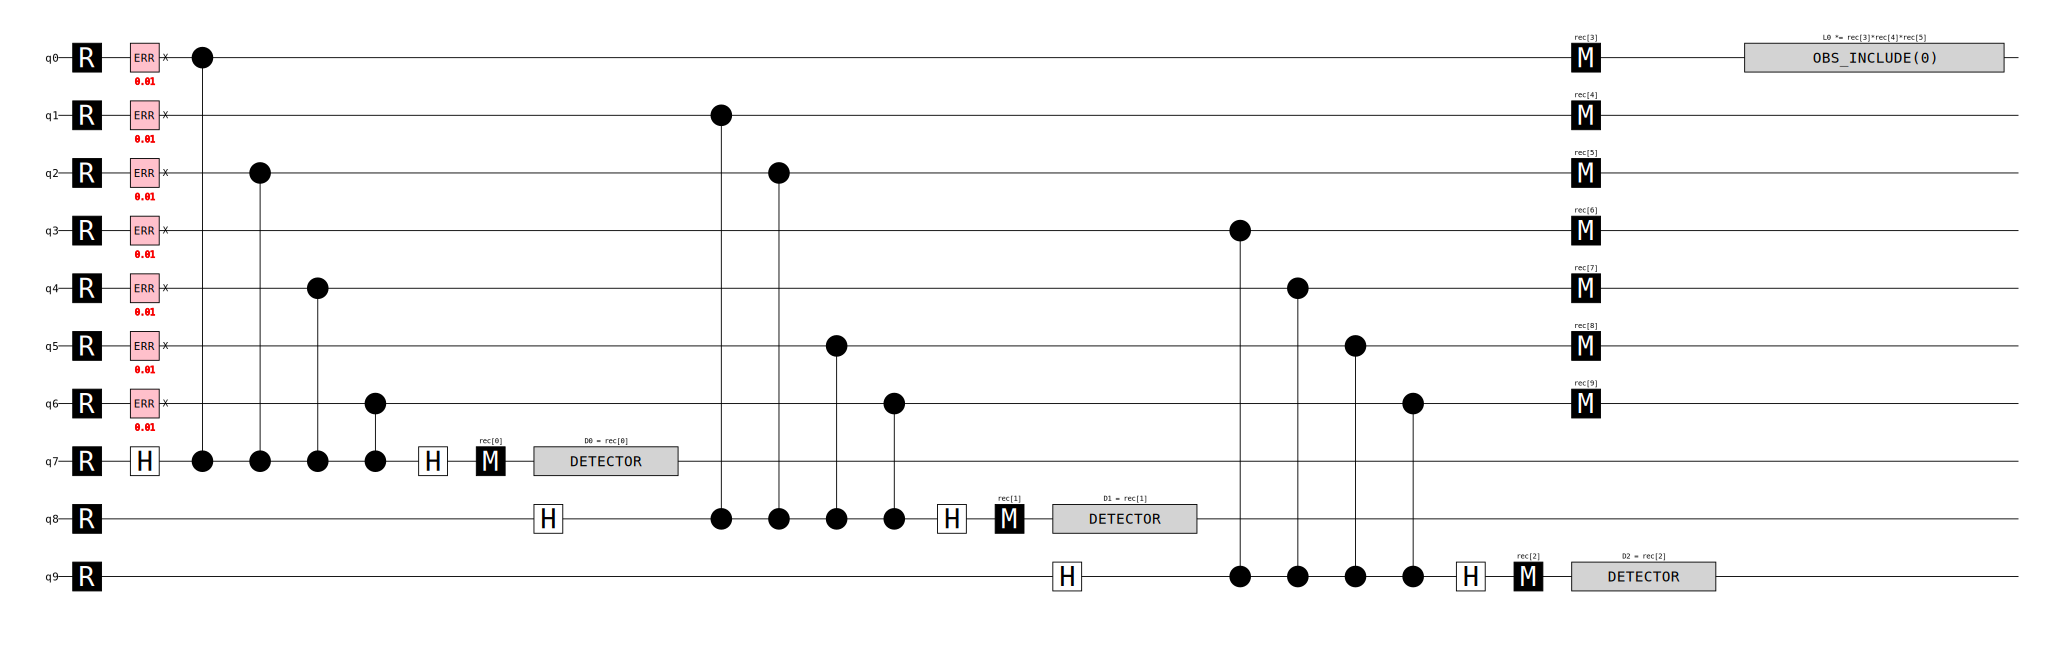

In [ ]:
def hamming_7_4_x_memory(p):
    c = stim.Circuit()

    # 7 data qubits: 0–6
    # 3 ancillas: 7–9
    data = list(range(7))
    anc = [7, 8, 9]

    # Initialize
    c.append("R", data + anc)

    # X noise on data
    # for q in data:
    #     c.append("X_ERROR", q, p)
    c.append("X_ERROR", data, p)

    #  Stabilizer 1: Z0 Z2 Z4 Z6
    c.append("H", anc[0])
    for q in [0, 2, 4, 6]:
        c.append("CZ", [anc[0], q])
    c.append("H", anc[0])
    c.append("M", anc[0])
    c.append("DETECTOR", [stim.target_rec(-1)])

    #  Stabilizer 2: Z1 Z2 Z5 Z6
    c.append("H", anc[1])
    for q in [1, 2, 5, 6]:
        c.append("CZ", [anc[1], q])
    c.append("H", anc[1])
    c.append("M", anc[1])
    c.append("DETECTOR", [stim.target_rec(-1)])

    #  Stabilizer 3: Z3 Z4 Z5 Z6
    c.append("H", anc[2])
    for q in [3, 4, 5, 6]:
        c.append("CZ", [anc[2], q])
    c.append("H", anc[2])
    c.append("M", anc[2])
    c.append("DETECTOR", [stim.target_rec(-1)])

    # Measure data
    c.append("M", data)

    # Define a logical observable:
    # Logical X = parity of qubits [0,1,2]
    c.append(
        "OBSERVABLE_INCLUDE",
        [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)],
        0
    )

    return c
c = hamming_7_4_x_memory(p = 0.01)
print(repr(c))
c.diagram('timeline-svg')

In [20]:
# num_shots = 100_000\
num_shots = 10
num_logical_errors = count_logical_errors(c, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1 wrong predictions (logical errors) out of 10 shots


This example is intended to illustrate how fundamental ideas from *classical error correction theory* can be systematically adapted and extended to the *quantum* domain.  Many of these principles, such as linearity, distance, redundancy, sparsity, and iterative decoding, have direct or carefully modified analogues in quantum error correction.

Quantum error-correcting codes must protect fragile quantum states against decoherence and operational errors while respecting uniquely quantum constraints, such as the no-cloning theorem and the requirement that error correction preserve quantum superposition and entanglement. Despite these challenges, classical constructions provide a powerful starting point. 7

### Concatenated codes

A caveat of Hamming codes is that their distance is fixed. As a result, the only way to vary the logical error rate is by changing the physical error rate. To observe genuine error suppression—i.e., improvement due to increasing code distance, it is necessary to concatenate Hamming codes, thereby constructing larger codes with higher distance. Exploring such concatenated constructions is a natural direction to pursue in this challenge.

**References:**
- G. D. Forney Jr. (1966), Concatenated Codes, IEEE Transactions on Information Theory 12, 1–11
- F. J. MacWilliams, N. J. A. Sloane (1977), The Theory of Error-Correcting Codes, North-Holland

### Reed–Solomon (RS) Codes

**Type and alphabet:**  
Linear non-binary cyclic block codes over a finite field $ \mathrm{GF}(q) $, usually constructed as evaluations of low-degree polynomials at distinct field elements.

**Key property:**  
For block length $ n \le q $ and dimension $ k $, Reed–Solomon codes achieve minimum distance  
$$
d = n - k + 1,
$$
meeting the Singleton bound and thus being *maximum-distance separable (MDS)* codes.

**Applications:**  
Widely used in CDs/DVDs, Blu-ray discs, deep-space and satellite communication, RAID storage systems, and QR codes due to their excellent burst-error and erasure correction capability.

**References:**
- I. S. Reed and G. Solomon, “Polynomial Codes over Certain Finite Fields,” *Journal of the Society for Industrial and Applied Mathematics*, vol. 8, no. 2, 1960.
- F. J. MacWilliams and N. J. A. Sloane, *The Theory of Error-Correcting Codes*, North-Holland, 1977.
- R. E. Blahut, *Theory and Practice of Error Control Codes*, Addison-Wesley, 1983.

---

### Binary Golay Codes

**Perfect codes:**  
The $(23,12,7)$ binary Golay code $ G_{23} $ is a *perfect* linear code: Hamming spheres of radius 3 around all codewords exactly partition $ \{0,1\}^{23} $.

**Parameters:**  
- Extended binary Golay code: $[24,12,8]$  
- Punctured Golay code: $[23,12,7]$

**Applications and structure:**  
Golay codes possess remarkable symmetry; their automorphism group is closely related to the Mathieu group $ M_{24} $. They were used in the Voyager space missions and are central objects in algebraic coding theory and finite group theory.

**References:**
- M. J. E. Golay, “Notes on Digital Coding,” *Proceedings of the IRE*, vol. 37, 1949.
- F. J. MacWilliams and N. J. A. Sloane, *The Theory of Error-Correcting Codes*, North-Holland, 1977.
- J. H. Conway and N. J. A. Sloane, *Sphere Packings, Lattices and Groups*, Springer, 1999.

---

### BCH Codes

**Definition:**  
Bose–Chaudhuri–Hocquenghem (BCH) codes are cyclic linear block codes over $ \mathrm{GF}(q) $ defined by generator polynomials whose roots are consecutive powers of a primitive element in an extension field.

**Design flexibility:**  
By selecting the number of consecutive roots, BCH codes guarantee a *designed minimum distance*, allowing systematic construction of families of binary and non-binary codes with tunable length, rate, and error-correcting capability.

**Relevance to quantum coding:**  
Nested BCH codes are frequently used in Calderbank–Shor–Steane (CSS) constructions, forming a key bridge between classical and quantum error correction.

**References:**
- R. C. Bose and D. K. Ray-Chaudhuri, “On a Class of Error Correcting Binary Group Codes,” *Information and Control*, 1960.
- A. Hocquenghem, “Codes Correcteurs d’Erreurs,” *Chiffres*, 1959.
- S. Lin and D. J. Costello, *Error Control Coding*, Pearson, 2004.

---

### Low-Density Parity-Check (LDPC) Codes

**Sparse-graph codes:**  
LDPC codes are linear block codes defined by sparse parity-check matrices, equivalently represented by sparse bipartite Tanner graphs. This structure enables efficient iterative decoding via belief propagation.

**Performance:**  
Well-designed LDPC ensembles operate close to the Shannon capacity with practical decoding complexity and are widely used in modern communication and storage systems.

**Quantum connection:**  
Structured LDPC codes (e.g., quasi-cyclic and protograph-based codes) serve as templates for quantum LDPC and hypergraph-product codes.

**References:**
- R. G. Gallager, “Low-Density Parity-Check Codes,” *IRE Transactions on Information Theory*, 1962.
- T. Richardson and R. Urbanke, *Modern Coding Theory*, Cambridge University Press, 2008.
- D. J. C. MacKay, *Information Theory, Inference, and Learning Algorithms*, Cambridge University Press, 2003.

---

### Polar Codes

**Capacity-achieving construction:**  
Polar codes, introduced by Arıkan, are linear block codes that achieve the symmetric capacity of binary-input memoryless channels through the phenomenon of *channel polarization*.

**Structure:**  
Recursive channel combining and splitting transform physical channels into synthesized bit-channels that asymptotically become either nearly noiseless or nearly useless. Information bits are sent over good channels, while bad channels are frozen.

**Standards:**  
Polar codes are used in 5G control channels, complementing LDPC codes employed for data channels.

**References:**
- E. Arıkan, “Channel Polarization: A Method for Constructing Capacity-Achieving Codes,” *IEEE Transactions on Information Theory*, vol. 55, no. 7, 2009.
- E. Arıkan, “A Performance Comparison of Polar Codes and Reed–Muller Codes,” *IEEE Communications Letters*, 2008.
- 3GPP TS 38.212, *NR; Multiplexing and Channel Coding*, 2018.
